## Imports

In [1]:
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud, get_single_color_func

from sherlock_helpers.constants import (
    DATA_DIR, 
    FIG_DIR, 
    GRID_SCALE, 
    SEMANTIC_PARAMS, 
    VECTORIZER_PARAMS
)
from sherlock_helpers.functions import (
    add_arrows, 
    corr_mean, 
    r2z, 
    show_source, 
    z2r
)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
%matplotlib inline

Helper functions and variables used across multiple notebooks can be found in `/mnt/code/sherlock_helpers/sherlock_helpers`, or on GitHub, [here](https://github.com/ContextLab/sherlock-topic-model-paper/tree/master/code/sherlock_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from sherlock_helpers.functions import show_source<br />    show_source(foo)</pre>

## Define/inspect some custom functions/classes

In [2]:
show_source(z2r)

In [3]:
show_source(r2z)

In [4]:
show_source(corr_mean)

In [5]:
def bootstrap_ci_plot(
    M, 
    ci=95, 
    n_boots=1000, 
    corrs=False,
    color=None, 
    alpha=0.2, 
    return_bounds=False, 
    label=None, 
    ax=None,
    line_kwargs=None,
    ribbon_kwargs=None
):
    # set defaults
    mean_func = corr_mean if corrs else np.mean
    ax = plt.gca() if ax is None else ax
    line_kwargs = {} if line_kwargs is None else line_kwargs
    ribbon_kwargs = {} if ribbon_kwargs is None else ribbon_kwargs
    if color is None:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    if 'color' not in ribbon_kwargs:
        ribbon_kwargs['color'] = color
 
    timepoints = np.arange(M.shape[0])
    obs_mean = mean_func(M, axis=1)
    
    # (n_tpts, n_obs, n_boots) column indices to subsample each row of M
    rand_ixs = np.random.randint(0, M.shape[1], size=(*M.shape, n_boots))
    # (n_tpts, n_boots) subsample means for each timepoint
    boots = np.take_along_axis(M[:, np.newaxis], rand_ixs, axis=2)
    boot_means = mean_func(boots, axis=1)
    # compute confidence intervals via percentile bootstrapping
    ci_low = np.percentile(boot_means, (100 - ci) / 2, axis=1)
    ci_high = np.percentile(boot_means, (ci + 100) / 2, axis=1)
    
    # draw plot
    ax.fill_between(timepoints, ci_low, ci_high, alpha=alpha, **ribbon_kwargs)
    ax.plot(timepoints, obs_mean, color=color, label=label, **line_kwargs)
    
    if return_bounds:
        return ax, ci_low, ci_high
    else:
        return ax

In [6]:
def topn(d, n):
    return dict(Counter(d).most_common(n))

In [7]:
def get_normalized_model(m, tm):
    m = np.dot(m, tm.components_)
    m -= m.mean(axis=0)
    m -= m.min()
    return m / m.max()

In [8]:
def plot_wordle(ax, textdict, maskpath=None):
    circle = np.array(Image.open(maskpath))
    wc = WordCloud(max_font_size=50, 
                   collocations=False, 
                   max_words=200, 
                   background_color="white", 
                   mask=circle, 
                   width=2000, 
                   height=1000, 
                   colormap=plt.cm.Reds)
    wc.generate_from_frequencies(textdict)
    ax.imshow(wc.recolor(color_func=grouped_color_func, random_state=3),
              interpolation="bilinear")
    ax.axis("off")

In [9]:
def plot_image(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        pass
    
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    im.image.axes = ax
    artists = []
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))
    return artists

In [10]:
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping
       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color 
                              for (color, words) in color_to_words.items() 
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

In [11]:
show_source(add_arrows)

## Set plotting params

In [12]:
cmap = plt.cm.Spectral
mpl.rcParams['pdf.fonttype'] = 42
sns.set_context('talk')
default_color = 'grey'
N_TOP = 50

## Load data

In [13]:
video_events = np.load(DATA_DIR.joinpath('video_events.npy'))
recall_events = np.load(DATA_DIR.joinpath('recall_events.npy'), allow_pickle=True)
avg_recall_events = np.load(DATA_DIR.joinpath('avg_recall_events.npy'), allow_pickle=True)
matches = np.load(DATA_DIR.joinpath('labels.npy'), allow_pickle=True)
text_corpus = np.load(DATA_DIR.joinpath('video_text.npy'), allow_pickle=True)
embeddings = np.load(DATA_DIR.joinpath('embeddings.npy'), allow_pickle=True)

video_embedding = embeddings[0]
recall_embeddings = embeddings[2]

## Compute distances, plot the result

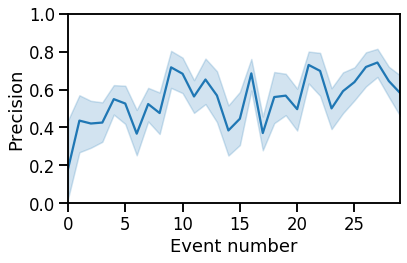

In [14]:
dists = np.transpose([(1 - cdist(video_events, sub, 'correlation')).max(axis=1) 
                      for sub in recall_events])

bootstrap_ci_plot(dists, corrs=True)
plt.xlim(0, 29)
plt.ylim(0, 1)
plt.xlabel('Event number')
plt.ylabel('Precision')
plt.tight_layout()
# plt.savefig(FIG_DIR.joinpath('tmp', 'precision.pdf'))
plt.show()

## Fit topic model to video annotation sliding windows

In [15]:
cv = CountVectorizer(**VECTORIZER_PARAMS['params'])
corpus_tf = cv.fit_transform(text_corpus)
tm = LatentDirichletAllocation(**SEMANTIC_PARAMS['params']).fit(corpus_tf)

In [16]:
# np.save(DATA_DIR.joinpath('count_vectorizer_model'), cv)
# np.save(DATA_DIR.joinpath('topic_model'), tm)

In [17]:
norm_video_events = get_normalized_model(video_events, tm)
norm_avg_recall_events = get_normalized_model(avg_recall_events, tm)

## Wordle figures

In [18]:
for seg in range(video_events.shape[0]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    video_weights = dict(zip(cv.get_feature_names(), norm_video_events[seg]))
    textdict_video = topn(video_weights, N_TOP)
    color_to_words = {'black': list(set(textdict_video))}
    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
    plot_wordle(ax1, textdict_video, maskpath=DATA_DIR.joinpath("half-moon-left.jpg"))
    
    recall_weights = dict(zip(cv.get_feature_names(), norm_avg_recall_events[seg]))
    textdict_recall = topn(recall_weights, N_TOP)
    color_to_words = {'black': list(set(textdict_recall))}
    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
    plot_wordle(ax2, textdict_recall, maskpath=DATA_DIR.joinpath("half-moon.jpg"))
    
    plt.subplots_adjust(wspace=-.5, hspace=-.5)
    fig.patch.set_visible(False)
#     plt.savefig(opj(tmp_dir, f'wordle_event{seg}.png'), dpi=300)
    plt.close()

### Weighted average of the event vectors by memorability

In [19]:
mdist = corr_mean(dists, axis=1)
rvec = np.zeros_like(video_events[0])
fvec = np.zeros_like(video_events[0])
rsum = 0
fsum = 0
for v, w in zip(video_events, mdist):
    rvec += v * w
    rsum += w
    fvec += v * (1 - w)
    fsum += (1 - w)
r = rvec / rsum
r = r - video_events.mean(0)
f = fvec / fsum
f = f - video_events.mean(0)

## Most memorable words

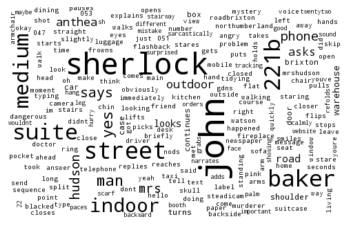

In [20]:
rweights = np.dot(r, tm.components_)
rdict = topn(dict(zip(cv.get_feature_names(), rweights)), 200)
color_to_words = {'black': list(set(rdict))}
grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)

fig, ax = plt.subplots(1, 1)
plot_wordle(ax, rdict, maskpath=DATA_DIR.joinpath("oval2.jpg"))
# plt.savefig(FIG_DIR.joinpath('tmp', 'most_memorable.png'), dpi=300)

## Least memorable words

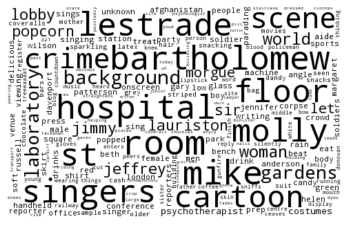

In [21]:
fweights = np.dot(f, tm.components_)
fdict = topn(dict(zip(cv.get_feature_names(), fweights)), 200)
color_to_words = {'black': list(set(fdict))}
grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)

fig, ax = plt.subplots(1, 1)
plot_wordle(ax, fdict, maskpath=DATA_DIR.joinpath("oval2.jpg"))
# plt.savefig(FIG_DIR.joinpath('tmp', 'least_memorable.png'), dpi=300)

## Trajectory distribution figure

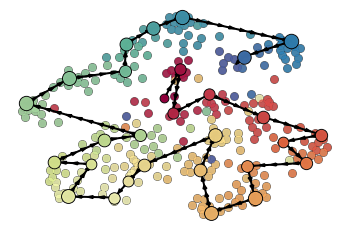

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i, (sub, sub_match) in enumerate(zip(recall_embeddings, matches)):
    for j, (p, m) in enumerate(zip(sub, sub_match)):
        ax.plot(p[0], 
                p[1], 
                'o', 
                c=cmap(m / video_embedding.shape[0]), 
                alpha=.75, 
                zorder=2, 
                markersize=7)
        
        ax.plot(p[0], p[1], 'o', c='k', alpha=.5, zorder=1, markersize=8)

for i, (xcoord, ycoord) in enumerate(video_embedding[:-1]):
    if i != len(video_embedding) - 1:
        next_xcoord, next_ycoord = video_embedding[i + 1]
        ax.plot((xcoord, next_xcoord), 
                (ycoord, next_ycoord), 
                c='k', 
                linewidth=2, 
                alpha=1)
        
    c = cmap(i / video_embedding.shape[0])
    ms = mdist[i] * GRID_SCALE / 3 + 5
    ax.plot(xcoord, ycoord, 'o', c=c, zorder=4, markersize=ms, alpha=.9)
    ax.plot(xcoord, ycoord, 'ko', zorder=3, markersize=ms + 2, alpha=.9)

add_arrows(ax, 
           video_embedding[:, 0], 
           video_embedding[:, 1], 
           zorder=3, 
           alpha=1, 
           color='k', 
           fill=True)
ax.axis('off')
# plt.savefig(FIG_DIR.joinpath('tmp', 'trajectory_distribution.pdf'))
plt.show()